In [11]:
import numpy as np
from IPython.display import Image
import math
from numpy import random
from geneticalgorithm import geneticalgorithm as ga
from sympy import Matrix, vector, init_printing
init_printing()

<br/><br/>**Parametry wejściowe**

In [12]:
R = 4 # liczba klas
N = 6 # liczba systemów

In [13]:
# lambda_0 dla każdej klasy

lambda_0 = [50, 100, 100, 100]

In [14]:
lambda_0

In [55]:
# macierze prawdopodobieństwa dla klas

p1 = np.array(
      [[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])
p2 = np.array(
      [[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])
p3 = np.array(
      [[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])
p4 = np.array(
      [[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [16]:
p = [p1, p2, p3, p4]

In [17]:
# parametr rozkładu czas obsługi

mi = np.array(
      [[160  , 160  , 160 , 160 ],
       [ 120 , 120  , 120 , 120 ],
       [110  , 110  , 110 , 110 ],
       [150  , 150  , 150 , 150 ],
       [130  , 130  , 130 , 130 ],
       [110  , 110  , 110 , 110 ]])

mi = 


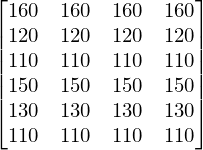

In [58]:
print("mi = ")
display(Matrix(mi))

In [18]:
# kanały obsługi
m_pocz = [1, 2, 4, 1, 2, 1]

<br/><br/>**Obiczanie lambda_matrix - współczynnik strumienia zgłoszeń klasy r w systemie i**

In [19]:
def lambda_values_for_class(class_no):
    A = np.transpose(p[class_no-1]) - np.identity(len(p[class_no-1]))
    l_0_vector = np.zeros(N)
    l_0_vector[0]= lambda_0[class_no-1]
    b = -l_0_vector
    
    return np.linalg.solve(A, b)

In [20]:
def lambda_matrix():
    lambda_matrix = np.zeros((N, R))
    for r in range(1, R+1):
        vals = lambda_values_for_class(r)
        for i in range(N):
            lambda_matrix[i,r-1] = vals[i]
    return lambda_matrix

lambda matrix:


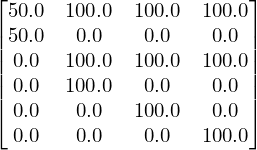

In [21]:
lambda_matrix = lambda_matrix()
print("lambda matrix:")
display(Matrix(lambda_matrix))

<br/><br/>**Obliczanie ro_matrix - względna intensywność obsługi klasy r w systemie i**

In [22]:
def calculate_ro_ir(i, r, m):
    return np.around(lambda_matrix[i,r-1]/(m[i]*mi[i][r-1]), decimals=5)

In [23]:
def calculate_ro_i(i, m):
    return sum([calculate_ro_ir(i, r, m) for r in range(R)])

In [24]:
def get_ro_matrix(m):
    ro_matrix = np.zeros((N, R))
    for r in range(1,R+1):
        for i in range(N):
            ro_matrix[i, r-1] = calculate_ro_ir(i, r, m)
    return ro_matrix

ro matrix:


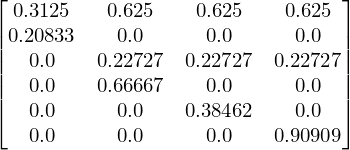

In [25]:
ro_matrix = get_ro_matrix(m_pocz)
print("ro matrix:")
display(Matrix(ro_matrix))

<br/><br/>**Obliczanie K_matrix - średnie liczby zgłoszeń klasy r w systemie i**



*   typ 1, m>1



In [26]:
def temp_first_part(ro, m):
    denom1 = sum([(((m * ro) ** k) / math.factorial(k)) for k in range(m-1)])
    denom2 = ((m*ro)**m) / (math.factorial(m)*(1-ro))
        
    return 1. / (denom1+denom2)

def calculate_pi_i(i, m):
    m_i = m[i]
    ro_i = calculate_ro_i(i,m)
    
    first_part = temp_first_part(ro_i, m_i)   
    second_part = ((m_i*ro_i)**m_i)/(math.factorial(m_i)*(1-ro_i))
        
    return first_part * second_part
    

In [27]:
def calculate_K_ir(i, r, m):
    m_i = m[i]
    ro_i = calculate_ro_i(i, m)
    ro_ir = calculate_ro_ir(i, r, m)
    mi_ro = m_i*ro_i
    
    first_part = m_i*ro_ir
    second_part = ro_ir/(1-ro_i)
    third_part = calculate_pi_i(i,m)
    return np.around(first_part + (second_part * third_part), decimals=5)


In [28]:
def get_K_matrix(m):
    K_matrix = np.zeros((N, R))
    
    for r in range(1,R+1):
        for i in range(N):
            K_matrix[i, r-1] = calculate_K_ir(i, r, m)
    
    return np.nan_to_num(K_matrix)

K matrix:


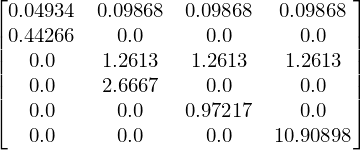

In [29]:
K_matrix = get_K_matrix(m_pocz)
print("K matrix:")
display(Matrix(K_matrix))

<br/><br/>**Obliczanie T_matrix - średni czas przebywania zgłoszenia klasy r w systemie i**

In [30]:
def get_T_ir(i, r, K_matrix):
    if lambda_matrix[i, r-1] == 0:
        return 0
    return np.around(K_matrix[i, r-1]/lambda_matrix[i, r-1], decimals=5)

def get_T_matrix(m):
    T_matrix = np.zeros((N, R))
    K_matrix = get_K_matrix(m)
    for r in range(R+1):
        for i in range(N):
            T_matrix[i,r-1] = get_T_ir(i, r, K_matrix)
    return np.nan_to_num(T_matrix)

In [31]:
T_matrix = get_T_matrix(m_pocz)
T_matrix

array([[0.00099, 0.00099, 0.00099, 0.00099],
       [0.00885, 0.     , 0.     , 0.     ],
       [0.     , 0.01261, 0.01261, 0.01261],
       [0.     , 0.02667, 0.     , 0.     ],
       [0.     , 0.     , 0.00972, 0.     ],
       [0.     , 0.     , 0.     , 0.10909]])

<br/><br/>**Obliczanie W_matrix - średni czas oczekiwania zgłoszenia klasy r w systemie i**

In [32]:
def get_W_matrix(m):
    W_matrix = np.zeros((N, R))
    T_matrix = get_T_matrix(m)
    W_matrix = T_matrix - 1/mi
    W_matrix[W_matrix<0] = 0
    return np.around(np.nan_to_num(W_matrix), decimals=5)

W matrix:


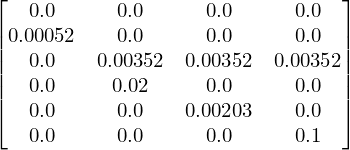

In [33]:
W_matrix = get_W_matrix(m_pocz)
print("W matrix:")
display(Matrix(W_matrix))

<br/><br/>**Obliczanie Q_matrix - średnia długość kolejki zgłoszeń klasy r w systemie i wyliczona na podstawie reguły Little’a**

In [34]:
def get_Q_matrix(m):
    Q_matrix = np.zeros((N, R))
    W_matrix = get_W_matrix(m)
    for r in range(R):
        for i in range(N):
            Q_matrix[i,r-1] = lambda_matrix[i,r-1]*W_matrix[i,r-1]
            
    return np.around(np.nan_to_num(Q_matrix), decimals=5)

Q matrix:


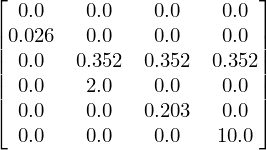

In [35]:
Q_matrix = get_Q_matrix(m_pocz)
print("Q matrix:")
display(Matrix(Q_matrix))

<br/><br/>**Optymalizacja**



*   Parametry wejściowe





C1 = 


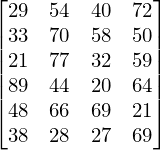

In [36]:
# C1 - koszty oczekiwania zgłoszenia klasy j w kolejce systemu i

C1 = random.randint(20,100, size=(N, R))
print("C1 = ")
display(Matrix(C1))

In [37]:
# C2 - koszty niezajętości kanałów obsługi w systemie i

C2 = random.randint(1, 10, size=N)
print("C2 = ")
display(Matrix(C2))

C2 = 



Lambda matrix:


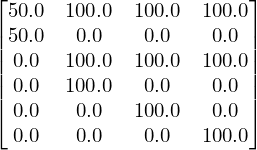

In [38]:
print("\nLambda matrix:")
display(Matrix(lambda_matrix))



*   Funkcja celu



In [39]:
def f_celu(m):
    m = np.array(m).astype(int)  
    suma = 0
    Q_matrix = get_Q_matrix(m)
    ro = [calculate_ro_i(i, m) for i in range(N)]
    ro = np.array(ro)
    if (np.any(ro >1)):
      suma += 10000
    m_nzi = (m-m*ro)
    for i in range(N):
        for r in range(R):
            suma = suma + C1[i,r]*Q_matrix[i,r] + C2[i]*m_nzi[i]
            
    return suma

In [40]:
f_celu(m_pocz)

In [41]:
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':50,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

In [42]:
varbound=np.array([[1,10]]*N)
model=ga(function=f_celu,dimension=N,variable_type='int',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

 The best solution found:                                                                           
 [5. 1. 5. 2. 2. 3.]

 Objective function:
 218.87038


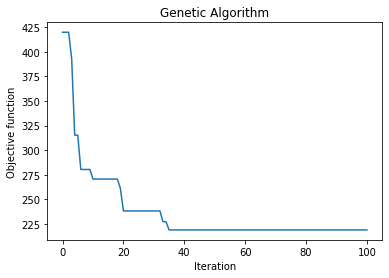

Rozwiązanie znalezione w 35 iteracji
Rozwiązanie:
 [5 1 5 2 2 3]

Koszt: 



Ro matrix:


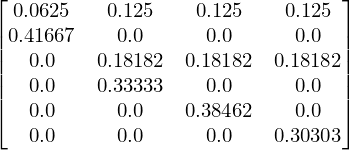


K matrix:


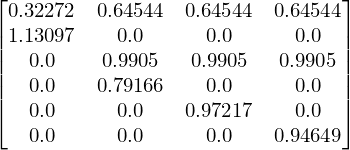


T matrix:


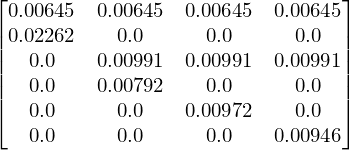


W matrix:


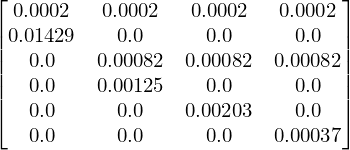


Q matrix:


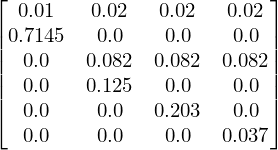

In [43]:
model.run()    
report = model.report
min_iter = report.index(min(report))
print(f"Rozwiązanie znalezione w {min_iter} iteracji")

opt_solution = model.best_variable
cost_val = f_celu(opt_solution)
opt_solution = opt_solution.astype(int)

print(f"Rozwiązanie:\n {opt_solution}\n")

print("Koszt: ")
display(cost_val)

print("\nRo matrix:")
display(Matrix(get_ro_matrix(opt_solution)))

print("\nK matrix:")
display(Matrix(get_K_matrix(opt_solution)))

print("\nT matrix:")
display(Matrix(get_T_matrix(opt_solution)))

print("\nW matrix:")
display(Matrix(get_W_matrix(opt_solution)))

print("\nQ matrix:")
display(Matrix(get_Q_matrix(opt_solution)))